# SEL 2017/18 - Practical Work 3 - CBR prototype for planning
*by Alberto Olivares Alarcos and Alejandro Suárez Hernández*

## 1. Introduction
 
In this document we present the work done for the third delivery of the *Supervised and Experimental Learning* (SEL) course. The main theme of this project is the design and implementation of a CBR system for planning. A CBR based on the use of several heuristics has been developed for general STRIPS-based domain. We exemplify this report with three different well known planning domains. We provide empirical results for these domain at the end of the document.

The whole project is available in Github (https://github.com/sprkrd/planning-cbr).

### 1.1. Theoretical principles of planning

We devote this section to briefly introduce the unfamiliar reader to the realm of planning. We target the problem of planning for arbitrary problems with **STRIPS**-like expressivity. A problem is given by a tuple $(\mathcal{D}, \mathcal{P})$, where $\mathcal{D}$ is the domain and $\mathcal{P}$ is a particular instance of the problem in this domain.

The domain $\mathcal{D}$ represents generic knowledge about the problem. This includes:

* A **type hierarchy** for the problem's objects.
* A set of **propositional predicates** that are used to describe the problem's states. The predicates are composed of a name and a list of optionally typed arguments.
* A set of *actions* or **operators**. At the same time, an action is composed of:
    * A list of optionally typed **parameters** (objects from the world).
    * A **precondition**, expressed as a conjunction of predicates. For an operator to be applicable in a given state, this precondition must be satisfied by the state.
    * An **add list**, describing the predicates that will be added to the state after the application of this operator.
    * A **delete list**, describing the predicates that will be deleted from the state after the application of this operator.
    * A real positive number that represents the **cost** for this action.

On the other hand, the instance $\mathcal{P}$ represents the facts of a specific problem. This includes:

* A set of optionally typed **objects** relevant for this problem.
* Specification of the initial state, as a set of predicates.
* Specification of the goal condition (it does not have to be a complete state), as a set of predicates.

Notice that the domain is generic and shared among all the problems of the same type (e.g. the blocks world or the Towers of Hanoi), while the instance is specific to each problem. Notice too that, when specifying the domain, the operators are typically left unground (i.e. with free variables as parameters), and are instantiated for each particular problem.

STRIPS adopts the closed-world assumption. That is: predicates that are present in the state are true, while predicates that are not are false. That is in contraposition to the open world assumption, in which predicates that are in the state are marked explicitly as true or false and predicates that are not in the state are unknown.

In this context, planning consists in finding an applicable sequence of operator that can be executed in chain from the initial state and that result in a state that satisfies the goal condition. That is, a sequence of operators $o_1, o_2, \dots, o_n$ such that

$$o_1(s_0) \rightarrow s_1$$
$$o_2(s_1) \rightarrow s_2$$
$$\dots $$
$$o_{n}(s_{n-1}) \rightarrow s_n$$
$$s_n \models g$$

In this work, we address this in the most general way possible. That is, we do not make any assumption over the underlying domain.


### 1.2. Basic principles of the CBR engine project

Our aim was to implement a CBR engine that operates in the framework introduced in the former section. The role of the CBR in our project is to infer the cost of the optimum plan between a state and a goal. Our CBR combines several planning heuristics (numerical attributes) in order to give an estimation of the optimum plan's cost. Ideally, this estimation should be better than each of the individual heuristics. That is, we seek to enable the planner to learn from experience (i.e. problems solved in the past) so it can perform better in the future. In our project, we have considered that the cost of performing an action is unitary, so plan cost and plan length are effectively the same.

An heuristic that is able to exactly compute the optimum cost is called perfect heuristic and it is often denoted as h\*. Therefore, in light of what we have just explained, the general idea of our work is to train a system that approximates h* as good as possible. This way, we can use our system to guide pathfinding and graph traversal heuristic search algorithms (IDA*, A*, etc.). We use A*, which guarantees to find the optimal plan if an only if the found heuristic is admissible, that is, it is smaller or equal to the perfect heuristic. Although the admissibility of a learned heuriscit cannot be always guaranteed, it is often desired to tradeoff optimality with search speed. That is, we prefer to find a good and reasonable plan quickly that spend a high amount of time in finding the optimum plan.

(Specifically, we do not look at the absolute value of the heuristic, but at the order that the heuristic produces in the states which are part of the plan.)

The Case Library Structure we have used is **k-d tree**, the reason is that we work with purely numerical cases which can be organised and retrieved efficiently following such a structure. Namely, each case is a vector of heuristics. We are trying to solve a regression problem, so we want to aggregate the retrieved cases' targets to estimate the optimum heuristic. We use the **Scikit learn**'s **knn** regressor for this. We train an base regressor with a bunch of easy problems solved with exhaustive search, and from that point on the CBR updates the knn's data base with the data discovered in subsequent problems.


### 1.3. Chosen application domain

For this practical work we have chosen three different domains: The Tower of Hanoi, Blocks World and Elevators. All of them are typical domains used in Planning. We present the three domains and show examples of them using blind search methods (BFS and IDS). We also use those methods as target in order to test our CBR system. 

Nevertheless, our project is quite ambitious because we have implemented it for general purpose. It can be apply to any kind of problem which can be written with STRIPS expressivity. 

#### 1.3.1. The Tower of Hanoi
The Tower of Hanoi is a mathematical game or puzzle often used in psychology. It consists of three rods or pegs and a number of disks of different sizes, which can slide onto any rod. The puzzle typically starts with all the disks stacked in the first peg (with the small disks on top of the bigger ones), although we consider a more general puzzle in which the initial configuration is arbitrary.

The objective of the puzzle is to reach a particular configuration of the disks, obeying the following simple rules:

1. Only one disk can be moved at a time.
2. Each move consists of taking the upper disk from one of the stacks and placing it on top of another stack.
3. No disk may be placed on top of a smaller disk.

We have defined the domain in Python and it contains a single operator: `move(?what-disk, ?from-object, ?to-object)`, which moves disk `?what` from object `?from` (either a peg or another disk) to object `?to` (also, either a peg or a disk). Our planning framework can take care of static preconditions. That is, it does not instantiate the move operator for moving a disk onto a smaller disk) so it is not necessary to encode static predicates in the state (the `smaller(?disk1,?disk2)` predicates that are typically seen in PDDL Hanoi domains).

We have also implemented a problem generator. The generator can create problems for any number of disks and pegs. It also allows random initial and ending configurations. Our first example will be fairly simple and will have 3 pegs, all the disks in the first peg in the initial state and all the disks in the third peg in the goal configuration. Although the goal in this case details the position of every disk, notice that this does not necessarily has to be the case always. The goal does not need to be a complete description of the end configuration. It is perfectly reasonable, and our framework allows it, to consider partial states (e.g. we want the biggest disk in the third peg, and we do not care about the rest).

Next we show an example problem and its resolution:

In [38]:
import planning
import random

from IPython.display import display

Init:


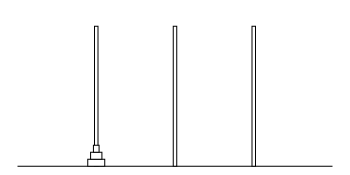

Goal:


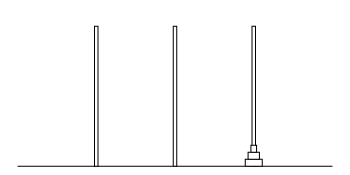

In [2]:
domain_name = "Hanoi"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 3, random=False)
# print(domain)
# print(problem)
print("Init:")
display(problem.init())
print("Goal:")
display(problem.goal())
# print("Applicable actions in 1st state:")
# l = list(filter(problem.init().can_apply, problem.operators()))
# print("\n".join(map(str, l)))
# print(planning.pddl_utility.pddl_actions(l))
# print(planning.pddl_utility.pddl_domain(domain, problem.operators()))
# print(planning.pddl_utility.pddl_problem(problem))

# with open("domain"+domain_name+".pddl", "w") as d, open("problem"+domain_name+".pddl","w") as p:
#     d.write(planning.pddl_utility.pddl_domain(domain, problem.operators()))
#     p.write(planning.pddl_utility.pddl_problem(problem))


[0.002s] Plan found with 7 action(s)
#Generated nodes: 24
Plan:
  move(disk01,disk02,peg3)
  move(disk02,disk03,peg2)
  move(disk01,peg3,disk02)
  move(disk03,peg1,peg3)
  move(disk01,disk02,peg1)
  move(disk02,peg2,disk03)
  move(disk01,peg1,disk02)
step 0


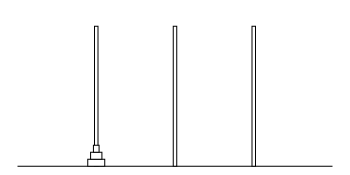

step 1


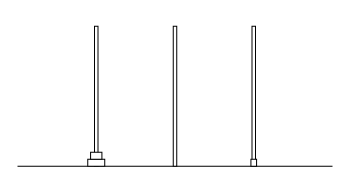

step 2


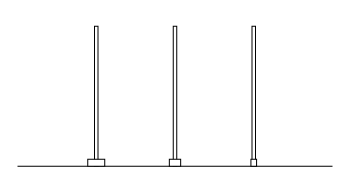

step 3


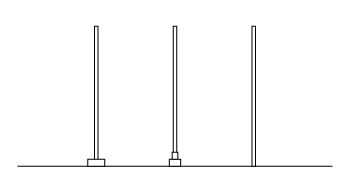

step 4


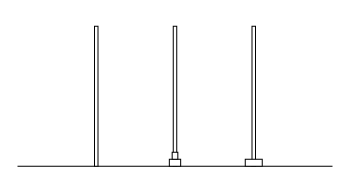

step 5


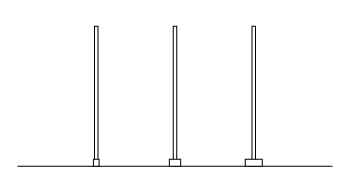

step 6


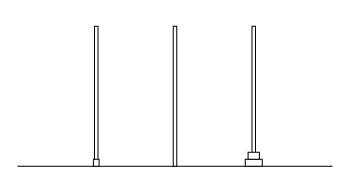

step 7


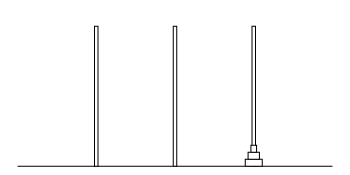

In [3]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if True: #len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

#### 1.3.2. Blocks World
The blocks world is one of the most famous planning domains in artificial intelligence. Imagine a set of wooden blocks of various shapes and colors sitting on a table. The goal is to build one or more vertical stacks of blocks. The catch is that only one block may be moved at a time: it may either be placed on the table or placed atop another block. Because of this, any blocks that are, at a given time, under another block cannot be moved. Moreover, some kinds of blocks cannot have other blocks stacked on top of them.

The simplicity of this toy world lends itself readily to symbolic or classical A.I. approaches, in which the world is modeled as a set of abstract symbols which may be reasoned about.

One relevant difference between our implementation of the domain with respect to the original one, is that our table is not infinite. Instead, there are a number of limited slots.

We have defined the domain in Python and it contains a two operators: `pick(?what-block, ?from-object)`, which picks block `?what` from object `?from` (either a slot of the table or another block) and `put(?what-block, ?to-object)`, which puts block `?what` onto object `?to` (also, either one position of the table or a block).

Here is an example problem and its resolution:

Init:


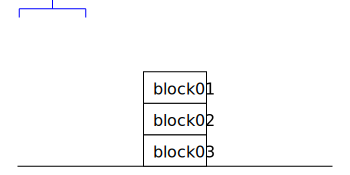

Goal:


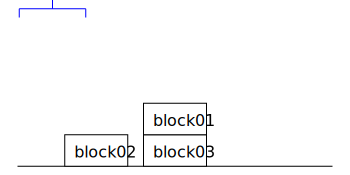

In [4]:
random.seed(45)

domain_name = "Blocks"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 3)
# print(domain)
# print(problem)
print("Init:")
display(problem.init())
print("Goal:")
display(problem.goal())
# print("Applicable actions in 1st state:")
# l = list(filter(problem.init().can_apply, problem.operators()))
# print("\n".join(map(str, l)))

# with open("domain"+domain_name+".pddl", "w") as d, open("problem"+domain_name+".pddl","w") as p:
#     d.write(planning.pddl_utility.pddl_domain(domain, problem.operators()))
#     p.write(planning.pddl_utility.pddl_problem(problem))


We can solve this problem so that we get the following result.

[0.002s] Plan found with 6 action(s)
#Generated nodes: 23
Plan:
  pick(block01,block02)
  put(block01,slot3)
  pick(block02,block03)
  put(block02,slot1)
  pick(block01,slot3)
  put(block01,block03)
step 0


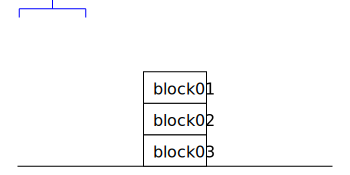

step 1


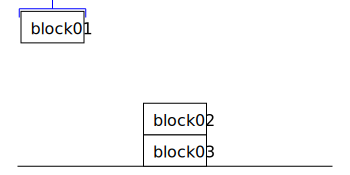

step 2


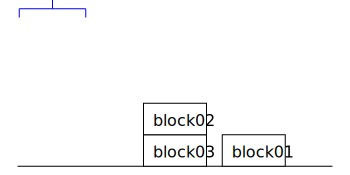

step 3


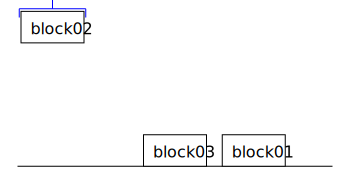

step 4


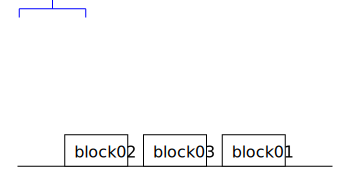

step 5


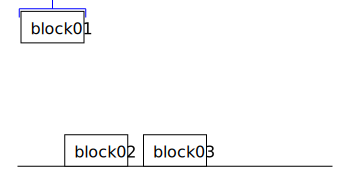

step 6


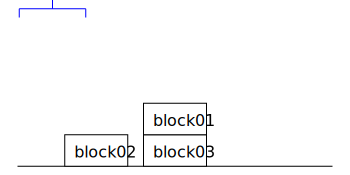

In [5]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if True: #len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

#### 1.3.3. Elevators Domain

Let us consider we have a building with several floors and people who want to go from one floor to another one. An elevator, starting from one of the floors, has to satisfy all people petitions. The resctrictions are the following:

1. The elevator can just move one floor each step
2. Just one person can get into/outo the elevator each step


We have defined the domain in Python and it contains a four operators: 

1. `board(?f-floor, ?p-passenger)`, which boards the passenger `?p` which is in the floor `?f`.
2. `depart(?f-floor, ?p-passenger)`, which departs the passenger `?p` in the floor `?f`. The passenger is now served.
3. `drive_up(?f1-floor, ?f2-floor)`, the lift goes up from floor `?f1` to floor `?f2`.
4. `drive_down(?f1-floor, ?f2-floor)`, the lift goes down from floor `?f1` to floor `?f2`.

Again, we show an example problem and resolution:

Init:


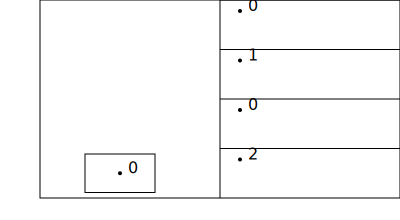

destin(passenger01,floor2)
destin(passenger02,floor2)
destin(passenger03,floor2)
origin(passenger01,floor1)
origin(passenger02,floor1)
origin(passenger03,floor3)

Goal:
served(passenger01)
served(passenger02)
served(passenger03)


In [6]:
random.seed(42)

domain_name = "Elevator"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 4)
# print(domain)
# print(problem)
print("Init:")
display(problem.init())
p_destin_orig = sorted([p for p in problem.init() if p[0] in ("origin", "destin")])
print(planning.predicate_list_to_str(p_destin_orig, delim="\n"), end="\n\n")
print("Goal:")
p_served = sorted([p for p in problem.goal() if p[0] == "served"])
print(planning.predicate_list_to_str(p_served, delim="\n"))
#display(problem.goal())
# print("Applicable actions in 1st state:")
# print("\n".join(map(str, filter(problem.init().can_apply, problem.operators()))))

# with open("domain"+domain_name+".pddl", "w") as d, open("problem"+domain_name+".pddl","w") as p:
#     d.write(planning.pddl_utility.pddl_domain(domain, problem.operators()))
#     p.write(planning.pddl_utility.pddl_problem(problem))

[0.011s] Plan found with 9 action(s)
#Generated nodes: 125
Plan:
  board(floor1,passenger01)
  board(floor1,passenger02)
  drive_up(floor1,floor2)
  depart(floor2,passenger01)
  depart(floor2,passenger02)
  drive_up(floor2,floor3)
  board(floor3,passenger03)
  drive_down(floor3,floor2)
  depart(floor2,passenger03)
step 0


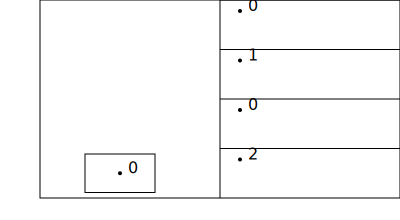

step 1


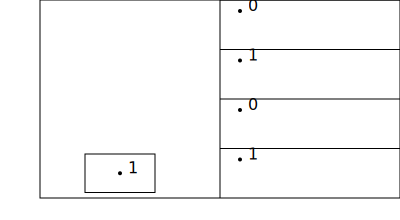

step 2


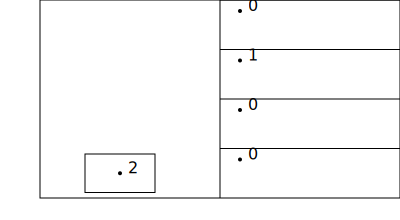

step 3


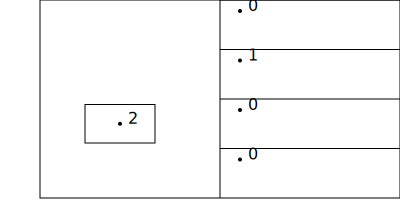

step 4


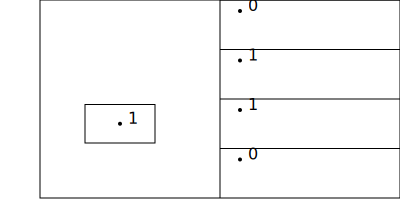

step 5


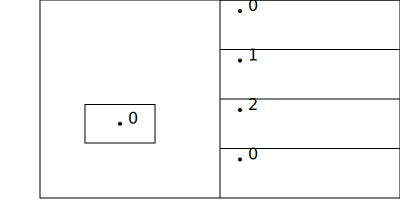

step 6


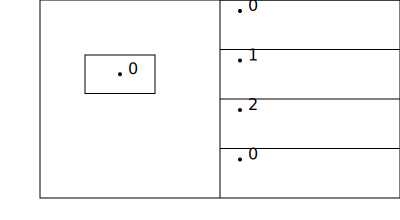

step 7


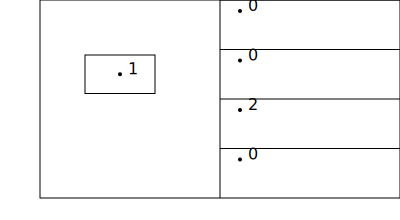

step 8


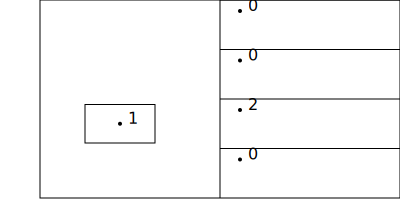

step 9


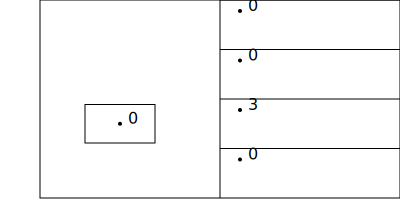

In [7]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    if True: #len(plan) < 10:
        print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))
        for i, state in enumerate(bfs.state_sequence()):
            print("step " + str(i))
            display(state)

## 2. Requirement Analysis of the CBR engine Project

In this section we analayse both, the requirements from a user perspective and from a technical point of view. 

### 2.1. Requirements: Users's perspective

Our system, general as it is, can be used in any sort of application in which is interesting the use of a planning system. In any domain in which a user has a problem which can be solved with planning techniques, our project is useful, so that, there are no requirements from the perspective of potential users. They will depend on the specific application of use. The main appeal of a planner capable of learning from its experience is its potential to reach the performance of domain-specific heuristic guided planners, but without having to explicitly code the specialized heuristic which can be very complicated and difficult to express.

Note that the work developed in this project could be used by specialized people with technical knowledge and this include both, researchers and product designers at private companies. 

Among the possible domains in which our system could be used we find: robotics, industrial organization, assembly lines or applications related to the use of satellites.

### 2.2. Requirements: Technical view

As it is explained just above, our system is too general to present requirements as specific as: maximum time response of the system or maximum memory size of the system. All these requirements will show up once the our potential users start using our system in a specific application domain. 

When designing our system we tried to address the following specific requirements:

1. The system should be faster than a conventional planner and expand less nodes when searching the solution.

2. The computed heuristic should be as precise as possible. 

3. The CBR system was thought to start learning with simple problems of the specific domain and continue doing so with more difficult and specific problems.

## 3. Functional Architecture of the CBR engine Project

In this project we have designed a system of general purpose, so that the functional architecture is quite simple to be used. Just four different entities take part in our Functional Architecture: 

* **Planner:** It implements an heuristic search algorithm. To guide the search, it can use:
    * Any of the heuristic implemented by ourselves ($h_{add}$, $rpg$, $goal\_counting$...)
    * Fast Downward planner as a proxy to compute any of the heuristics that come with the planner
    * Our continuous learning CBR.
* **Domain:** The domain has to be coded (just once) by the user. In order to do so, it is necessary to follow the same syntaxis we have used for our three domains, which is quite intuitive and tries to be as close as possible to PDDL. This is one of the inputs of our CBR system.
* **Problem:** Again, the problem has to be written by the user and it will be another input of our Planner. For our experiments, the problems will be generated randomly.
* **Plan:** This is the output of our system, the final plan with the sequence to be performed in order to solve the input problem. 

Below, we can see an image of how this four elements interact.

<img src='report_figures/functional_architecture.png'>


## 4. Proposed CBR engine Project solution design:

In this section we analyse in depth the design of our CBR engine: the Case Structure and Case Library Structure and the methods used for every CBR cycle step.

### 4.1. Case Structure and Case Library Structure designed

As said in the introduction of this document, our cases are vectors of heuristics. 

We have resorted to the Fast Downward planning system [1] (downloadable at http://www.fast-downward.org/) to compute a great deal of heuristics. Fast Downward is a classical planning system based on heuristic search. It can deal with general deterministic planning problems encoded in the propositional fragment of PDDL2.2, including advanced features like ADL expressivity (which, of course, it is not used since we are restricting ourselves to STRIPS). 

Although we have effectively managed to interface with the planner to retrieve these heuristics, each call requires a very long time (more than 100ms in our computers, which yields an unpractically high planning time when thousands of states have to be evaluated), so it is not practical for a production system. Nonetheless, Fast Downward has been useful to learn how the CBR would benefit from using a wide range of heuristics if we could implement them natively in Python.

Specificially, we have used eight different heuristics from Fast Downward (3 of which are the ones we have also implemented in Python). This means that a CBR based on Fast Downward operates with 8 numerical inputs:

- Additive (add)
- Additive CEGAR (cegar) 
- Causal Graph (cg)
- Canonical PDB (cpdbs)
- FF (ff)
- Goal Count (gloalcount)
- Max Heuristic (hmax)
- Landmark Cut (lmcut)

It goes beyond the scope of this document to detail these heuristics thoroughly.

Since computing these heuristics externally has associated a large overhead, we decided to implement some of the heuristics in Python. However, due to time constraints we could implement only the additive heuristic, the Relaxed planning graph heuristic ($ rpg $, same as $ h_{max} $ above for unitary costs) and $ goalcount $.

Regarding the Case Library Structure, we have used *k-d tree*, which is useful for retrieve in sublinear time the most similar cases, in our case, the vector of heuristics. The value of `d` corresponds to the number of heuristics we use, eitght.

### 4.2. Methods of every CBR cycle step

Case-based reasoning has been formalized for purposes of computer reasoning as a four-step process:

- **Retrieve:** Given a target problem, retrieve from memory cases relevant to solving it. We select the most similar vectors of heuristics and their associated targets (actual length of the plan) via K-Nearest Neighbors (KNN) algorithm. The value of K has been chosen empirically after some experiments. This choice can be improved in future versions of our system.
- **Reuse (Adaptation):** Map the solution from the previous case to the target problem. This may involve adapting the solution as needed to fit the new situation. To do so, we just perform a weighted average the targets using the inverse of the distance to the current case as a the weight of each retrieved case.
- **Revise:** Having mapped the previous solution to the target situation, test the new solution in the real world (or a simulation) and, if necessary, revise. After computing the plan, we use the length of the actual plan to annotate each of the states in the trajectory from the initial state to the goal. Although the generated plan is not necessarily optimal, this still helps
- **Retain:** After the solution has been successfully adapted to the target problem, store the resulting experience as a new case in memory. We have decided to add each vector of heuristics and its associated revised length to the data base, so they can be used in the future.

## 5. Testing

We will test the effectiveness of the KNN approach to predict the actual plan length associated to a particular vector of heuristics. This is done before applying the CBR full pipeline and continuous learning, with the intent of estimating the performance of a CBR that has been solving problems for a long time.

To do this, we generate several simple random problems for each domain (for generating the results of this report, we have used 1000 examples of each). Then we solve each problem with a search algorithm that is guaranteed to solve the problem optimally. We store the heuristics computed by Fast Downward in a matrix (input attributes) and the length of the plan in a vector (output target). Then we perform the classical train/test split and feed a KNN regressor with the train data. After that, we compute two sources of error in the test set:
* The RMS (Root Mean Square) error between the predictions and the targets
* The ranking error. This is, we check all the pairs of test examples and see whether the order induced by the target differs from the order induced by the prediction.

First of all, in order to give a flavour of the heuristic's behaviour, let us plot some relations among them and with respect to the optimal planning length:

**Hanoi**

In [19]:
g = planning.heuristics.AccumulatedCost()
hadd = planning.heuristics.AdditiveHeuristic()
rpg = planning.heuristics.RelaxedPlanningGraphHeuristic()
hlinear = planning.heuristics.LinearCombination([g, rpg], (1, 1)) # 5 A-star with additive heuristic
h = planning.heuristics.ConcatenateHeuristic([hlinear, rpg])

In [ ]:
domain = planning.domains["Hanoi"]

import random
import tqdm
import numpy as np
import os

random.seed(42)

m = 4 # 4-peg Hanoi towers

load = True

datadir = os.path.join("data", "hanoi", str(m))

try:
    os.makedirs(datadir)
except OSError:
    pass

X_file = os.path.join(datadir, "X.npy")
y_file = os.path.join(datadir, "y.npy")

if load:
    X = np.load(X_file)
    y = np.load(y_file)
else:

    X = []
    y = []

    N = 1000

    generated = set()
    
    # Available heuristics:
    # "add()", "ff()", "cg()", "lmcut()", "cegar()", 
    # "hmax()", "cpdbs()", "cea()", "zopdbs()", "goalcount()"
    fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()",
                                         "hmax()", "cpdbs()", "goalcount()")
#     fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()")

    for _ in tqdm.tqdm_notebook(range(N)):
        while True:
            n = random.randint(3, 5)
    #         m = random.randint(3, 4)
            problem = domain.generate_problem(n, m, random=True)
            if not problem.trivial() and (problem.init(), problem.goal()) not in generated:
                break
        generated.add((state, problem.goal()))
        bfs = planning.BestFirstSearch(problem, verbose=0, timeout=300.0, node_bound=20000,
                                       heuristic=h, close_forever=False)
        status = bfs()
        if status == planning.search.FOUND:
            plan_len = len(bfs.plan())
            X.append(fd.h(problem.init(), problem.goal()))
            y.append(plan_len)
#             for i, state in enumerate(bfs.state_sequence()):
#                 generated.add((state, problem.goal()))
#                 X.append(fd.h(state, problem.goal()))
#                 y.append(plan_len - i)

    X = np.array(X)
    y = np.array(y)
    
    np.save(X_file, X)
    np.save(y_file, y)

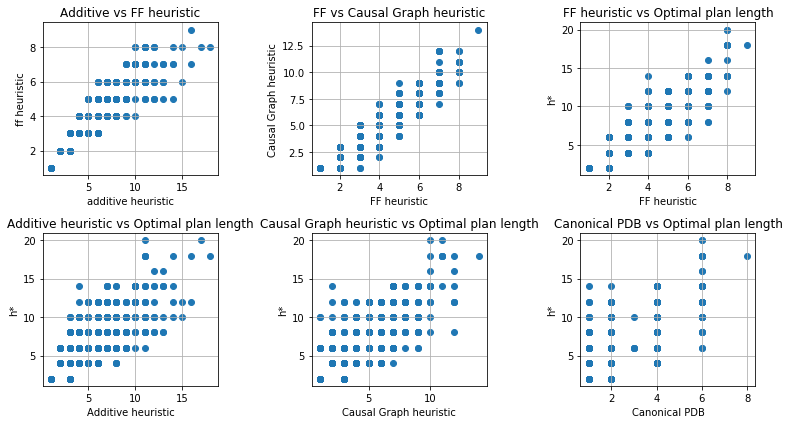

In [28]:
import matplotlib as mlp
%matplotlib inline
plt = mlp.pyplot
plt.rcParams["figure.figsize"] = [11, 6]
mlp.rcParams["figure.dpi"] = 72

plt.subplot(2, 3, 1)
plt.scatter(X[:,0], X[:,1])
plt.grid("on")
plt.xlabel("additive heuristic")
plt.ylabel("ff heuristic")
plt.title("Additive vs FF heuristic")

plt.subplot(2, 3, 2)
plt.scatter(X[:,1], X[:,2])
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("Causal Graph heuristic")
plt.title("FF vs Causal Graph heuristic")

plt.subplot(2, 3, 3)
plt.scatter(X[:,1], y)
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("h*")
plt.title("FF heuristic vs Optimal plan length")

plt.subplot(2, 3, 4)
plt.scatter(X[:,0], y)
plt.grid("on")
plt.xlabel("Additive heuristic")
plt.ylabel("h*")
plt.title("Additive heuristic vs Optimal plan length")

plt.subplot(2, 3, 5)
plt.scatter(X[:,2], y)
plt.grid("on")
plt.xlabel("Causal Graph heuristic")
plt.ylabel("h*")
plt.title("Causal Graph heuristic vs Optimal plan length")

plt.subplot(2, 3, 6)
plt.scatter(X[:,-2], y)
plt.grid("on")
plt.xlabel("Canonical PDB")
plt.ylabel("h*")
plt.title("Canonical PDB vs Optimal plan length")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.linalg import sqrtm

from sklearn import neighbors
from sklearn.model_selection import cross_val_score

psplit = 0.8

n = X.shape[0]
n_train = int(n*psplit)
n_test = n - n_train

# weights = [1,1,1,1,1,1,1,1]

X_train = X[:n_train,:]
y_train = y[:n_train]

# V = np.matrix(np.cov(X_train.T))
# VI_sqrt = sqrtm(V.I)

# X_train = np.matmul(X_train, VI_sqrt)*weights

X_test = X[n_train:,:]
# X_test = np.matmul(X[n_train:, columns], VI_sqrt)*weights
y_test = y[n_train:]

knn = neighbors.KNeighborsRegressor(4, weights="distance")

knn.fit(X_train, y_train)

y_ = knn.predict(X_test)

# print(y_test[10:20])
# print(y_[10:20])
# print(X_test[10:20,:])

error = np.sqrt(np.sum((y_ - y_test)**2)/n_test)

print("RMS error: {:.02}".format(error))

ranking_errors = 0
ranking_errors_simple = 0

for i in range(n_test):
    for j in range(n_test):
        y1, y1_ = y_test[i], y_[i]
        y2, y2_ = y_test[j], y_[j]
        x1, x2 = X_test[i,0], X_test[j,0]
        if y1 < y2 and y1_ >= y2_:
            ranking_errors += 1
        elif y1 > y2 and y1_ <= y2_:
            ranking_errors += 1
        if y1 < y2 and x1 >= x2:
            ranking_errors_simple += 1
        elif y1 > y2 and x1 <= x2:
            ranking_errors_simple += 1
            
print("Ranking error (KNN): {:.02f}%".format(100*ranking_errors/(n_test*n_test)))
print("Ranking error (hadd): {:.02f}%".format(100*ranking_errors_simple/(n_test*n_test)))

In [ ]:
domain = planning.domains["Blocks"]

import random
import tqdm
import numpy as np
import os

random.seed(42)

load = True

datadir = os.path.join("data", "blocks")

try:
    os.makedirs(datadir)
except OSError:
    pass

X_file = os.path.join(datadir, "X.npy")
y_file = os.path.join(datadir, "y.npy")

if load:
    X = np.load(X_file)
    y = np.load(y_file)
else:

    X = []
    y = []

    N = 1000

    generated = set()
    
    # Available heuristics:
    # "add()", "ff()", "cg()", "lmcut()", "cegar()", 
    # "hmax()", "cpdbs()", "cea()", "zopdbs()", "goalcount()"
    fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()",
                                         "hmax()", "cpdbs()", "goalcount()")
#     fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()")

    for _ in tqdm.tqdm_notebook(range(N)):
        while True:
            n = random.randint(3, 5)
            m = random.randint(3, 5) # number of slots
            problem = domain.generate_problem(n, m, forced_goal=False)
            if not problem.trivial() and (problem.init(), problem.goal()) not in generated:
                break
        generated.add((state, problem.goal()))
        bfs = planning.BestFirstSearch(problem, verbose=0, timeout=30.0, node_bound=20000,
                                       heuristic=h, close_forever=False)
        status = bfs()
        if status == planning.search.FOUND:
            plan_len = len(bfs.plan())
            X.append(fd.h(problem.init(), problem.goal()))
            y.append(plan_len)
#             for i, state in enumerate(bfs.state_sequence()):
#                 generated.add((state, problem.goal()))
#                 X.append(fd.h(state, problem.goal()))
#                 y.append(plan_len - i)

    X = np.array(X)
    y = np.array(y)
    
    np.save(X_file, X)
    np.save(y_file, y)

**Blocks**

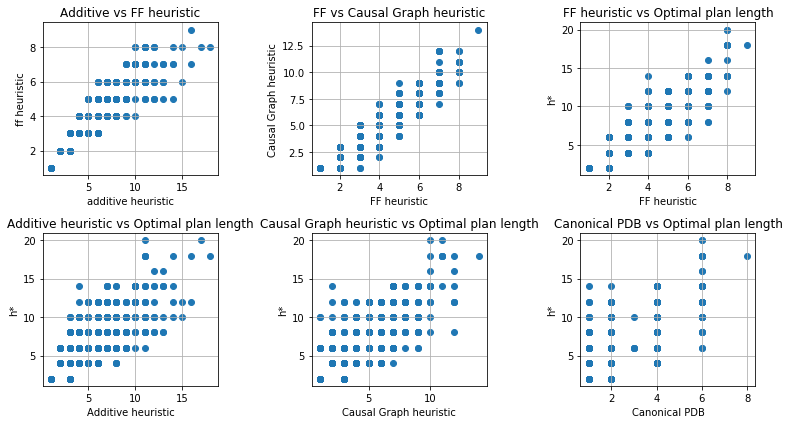

In [27]:
import matplotlib as mlp
%matplotlib inline
plt = mlp.pyplot
plt.rcParams["figure.figsize"] = [11, 6]
mlp.rcParams["figure.dpi"] = 72

plt.subplot(2, 3, 1)
plt.scatter(X[:,0], X[:,1])
plt.grid("on")
plt.xlabel("additive heuristic")
plt.ylabel("ff heuristic")
plt.title("Additive vs FF heuristic")

plt.subplot(2, 3, 2)
plt.scatter(X[:,1], X[:,2])
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("Causal Graph heuristic")
plt.title("FF vs Causal Graph heuristic")

plt.subplot(2, 3, 3)
plt.scatter(X[:,1], y)
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("h*")
plt.title("FF heuristic vs Optimal plan length")

plt.subplot(2, 3, 4)
plt.scatter(X[:,0], y)
plt.grid("on")
plt.xlabel("Additive heuristic")
plt.ylabel("h*")
plt.title("Additive heuristic vs Optimal plan length")

plt.subplot(2, 3, 5)
plt.scatter(X[:,2], y)
plt.grid("on")
plt.xlabel("Causal Graph heuristic")
plt.ylabel("h*")
plt.title("Causal Graph heuristic vs Optimal plan length")

plt.subplot(2, 3, 6)
plt.scatter(X[:,-2], y)
plt.grid("on")
plt.xlabel("Canonical PDB")
plt.ylabel("h*")
plt.title("Canonical PDB vs Optimal plan length")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.linalg import sqrtm

from sklearn import neighbors
from sklearn.model_selection import cross_val_score

psplit = 0.8

n = X.shape[0]
n_train = int(n*psplit)
n_test = n - n_train

# weights = [1,1,1,1,1,1,1,1]

X_train = X[:n_train,:]
y_train = y[:n_train]

# V = np.matrix(np.cov(X_train.T))
# VI_sqrt = sqrtm(V.I)

# X_train = np.matmul(X_train, VI_sqrt)*weights

X_test = X[n_train:,:]
# X_test = np.matmul(X[n_train:, columns], VI_sqrt)*weights
y_test = y[n_train:]

knn = neighbors.KNeighborsRegressor(4, weights="distance")

knn.fit(X_train, y_train)

y_ = knn.predict(X_test)

# print(y_test[10:20])
# print(y_[10:20])
# print(X_test[10:20,:])

error = np.sqrt(np.sum((y_ - y_test)**2)/n_test)

print("RMS error: {:.02}".format(error))

ranking_errors = 0
ranking_errors_simple = 0

for i in range(n_test):
    for j in range(n_test):
        y1, y1_ = y_test[i], y_[i]
        y2, y2_ = y_test[j], y_[j]
        x1, x2 = X_test[i,0], X_test[j,0]
        if y1 < y2 and y1_ >= y2_:
            ranking_errors += 1
        elif y1 > y2 and y1_ <= y2_:
            ranking_errors += 1
        if y1 < y2 and x1 >= x2:
            ranking_errors_simple += 1
        elif y1 > y2 and x1 <= x2:
            ranking_errors_simple += 1
            
print("Ranking error (KNN): {:.02f}%".format(100*ranking_errors/(n_test*n_test)))
print("Ranking error (hadd): {:.02f}%".format(100*ranking_errors_simple/(n_test*n_test)))

**Elevators**

In [ ]:
domain = planning.domains["Elevator"]

import random
import tqdm
import numpy as np
import os

random.seed(42)

m = 4 # 4-peg Hanoi towers

load = True

datadir = os.path.join("data", "elevators")

try:
    os.makedirs(datadir)
except OSError:
    pass

X_file = os.path.join(datadir, "X.npy")
y_file = os.path.join(datadir, "y.npy")

if load:
    X = np.load(X_file)
    y = np.load(y_file)
else:

    X = []
    y = []

    N = 1000

    generated = set()
    
    # Available heuristics:
    # "add()", "ff()", "cg()", "lmcut()", "cegar()", 
    # "hmax()", "cpdbs()", "cea()", "zopdbs()", "goalcount()"
    fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()",
                                         "hmax()", "cpdbs()", "goalcount()")
#     fd = planning.heuristics.FDHeuristic(domain, "add()", "ff()", "cg()", "lmcut()", "cegar()")

    for _ in tqdm.tqdm_notebook(range(N)):
        while True:
            n = random.randint(1, 5)
            m = random.randint(3, 4)
            problem = domain.generate_problem(n, m, goal=False)
            if not problem.trivial() and (problem.init(), problem.goal()) not in generated:
                break
        generated.add((state, problem.goal()))
        bfs = planning.BestFirstSearch(problem, verbose=0, timeout=300.0, node_bound=20000,
                                       heuristic=h, close_forever=False)
        status = bfs()
        if status == planning.search.FOUND:
            plan_len = len(bfs.plan())
            X.append(fd.h(problem.init(), problem.goal()))
            y.append(plan_len)
#             for i, state in enumerate(bfs.state_sequence()):
#                 generated.add((state, problem.goal()))
#                 X.append(fd.h(state, problem.goal()))
#                 y.append(plan_len - i)

    X = np.array(X)
    y = np.array(y)
    
    np.save(X_file, X)
    np.save(y_file, y)

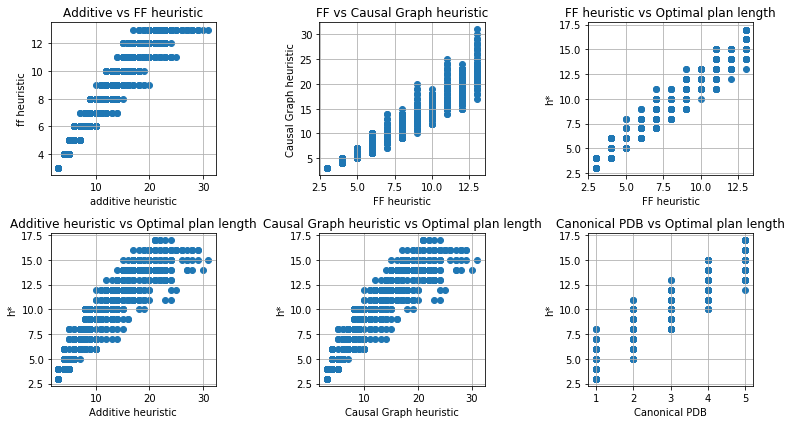

In [36]:
import matplotlib as mlp
%matplotlib inline
plt = mlp.pyplot
plt.rcParams["figure.figsize"] = [11, 6]
mlp.rcParams["figure.dpi"] = 72

plt.subplot(2, 3, 1)
plt.scatter(X[:,0], X[:,1])
plt.grid("on")
plt.xlabel("additive heuristic")
plt.ylabel("ff heuristic")
plt.title("Additive vs FF heuristic")

plt.subplot(2, 3, 2)
plt.scatter(X[:,1], X[:,2])
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("Causal Graph heuristic")
plt.title("FF vs Causal Graph heuristic")

plt.subplot(2, 3, 3)
plt.scatter(X[:,1], y)
plt.grid("on")
plt.xlabel("FF heuristic")
plt.ylabel("h*")
plt.title("FF heuristic vs Optimal plan length")

plt.subplot(2, 3, 4)
plt.scatter(X[:,0], y)
plt.grid("on")
plt.xlabel("Additive heuristic")
plt.ylabel("h*")
plt.title("Additive heuristic vs Optimal plan length")

plt.subplot(2, 3, 5)
plt.scatter(X[:,2], y)
plt.grid("on")
plt.xlabel("Causal Graph heuristic")
plt.ylabel("h*")
plt.title("Causal Graph heuristic vs Optimal plan length")

plt.subplot(2, 3, 6)
plt.scatter(X[:,-2], y)
plt.grid("on")
plt.xlabel("Canonical PDB")
plt.ylabel("h*")
plt.title("Canonical PDB vs Optimal plan length")

plt.tight_layout()
plt.show()

These plots indicate that the heuristics are indeed correlated to the optimum length of the plan, some more sparsely than other. This is, of course, as expected, but it also implies that the attributes are correlated among them. This is, in general, something that we would like to avoid in most of Machine Learning techniques, and it is typically addressed with whitening transforms (e.g. multiplying the data by the square root of its covariance matrix) or orthogonalization. However, it is not much of an concern with KNN, and dealing explicitly with this issue has led to results that are actually worse than the ones presented below.

We have computed the error of the KNN regressor and represented it in the following table:

| Domain    | RMS error | Ranking error (KNN) | Ranking error ($h_{add}$) |
|----------:|----------:|--------------------:|----------------------------:|
| Hanoi     |      0.85 |               5.57% |                      13.73% |
| Blocks    |      1.00 |               2.00% |                      14.42% |
| Elevators |      0.70 |               3.62% |                       9.31% |

The first two error columns refer to the KNN regressor itself, while the third one refers to the ranking error of one of the top performing heuristics. From this table of results it would seem that the KNN regressor has the potential to perform well in these domains.

Unfortunatelly, when switching to continuous learning, we have had trouble collecting big samples of data for evaluating appropriately the CBR because of the enormous overhead of the Python-Fast Downward interaction. However, so far the tentative results in the Hanoi problem (not quantitatively measured) have been discouraging because a search algorithm that uses the CBR actually expands more nodes than one that employs $ h_{add} $ as heuristic. We have reasons to believe that this is because of the high difficulty of the Hanoi problem with respect to the other domains. We also believe that another possible cause for this is that KNN, in its most standard form, is not adequate for solving this kind of problems.

In the future, it is our intention to confirm and extend these results.

In [ ]:
from scipy.linalg import sqrtm

from sklearn import neighbors
from sklearn.model_selection import cross_val_score

psplit = 0.8

n = X.shape[0]
n_train = int(n*psplit)
n_test = n - n_train

# weights = [1,1,1,1,1,1,1,1]

X_train = X[:n_train,:]
y_train = y[:n_train]

# V = np.matrix(np.cov(X_train.T))
# VI_sqrt = sqrtm(V.I)

# X_train = np.matmul(X_train, VI_sqrt)*weights

X_test = X[n_train:,:]
# X_test = np.matmul(X[n_train:, columns], VI_sqrt)*weights
y_test = y[n_train:]

knn = neighbors.KNeighborsRegressor(4, weights="distance")

knn.fit(X_train, y_train)

y_ = knn.predict(X_test)

# print(y_test[10:20])
# print(y_[10:20])
# print(X_test[10:20,:])

error = np.sqrt(np.sum((y_ - y_test)**2)/n_test)

print("RMS error: {:.02}".format(error))

ranking_errors = 0
ranking_errors_simple = 0

for i in range(n_test):
    for j in range(n_test):
        y1, y1_ = y_test[i], y_[i]
        y2, y2_ = y_test[j], y_[j]
        x1, x2 = X_test[i,0], X_test[j,0]
        if y1 < y2 and y1_ >= y2_:
            ranking_errors += 1
        elif y1 > y2 and y1_ <= y2_:
            ranking_errors += 1
        if y1 < y2 and x1 >= x2:
            ranking_errors_simple += 1
        elif y1 > y2 and x1 <= x2:
            ranking_errors_simple += 1
            
print("Ranking error (KNN): {:.02f}%".format(100*ranking_errors/(n_test*n_test)))
print("Ranking error (hadd): {:.02f}%".format(100*ranking_errors_simple/(n_test*n_test)))

## 6. Discussion

A KNN armed with a reasonably big training data set seems quite capable of obtaining a low regression error, as it became apparent in the previous section. However, in our tentative experiments in the Hanoi domain, the continuous learning CBR did not perform as well as these results suggest. We have reasons to believe that achieving a low RMS alone is not a strong enough guarantee for outperforming classical heuristic search in terms of expanded nodes. This suspicion is confirmed by some authors [2] that argue that more important than approximating the value of the target is inducing the same relative order among states. For this very reason, in the previous section we have shown the ranking error in addition to the RMS error.

Although a fully trained KNN seems to achieve a lower ranking error than one of the top performing heuristics, we have no obvious way to optimize the induced order instead of the absolute value. This is a matter of further research.

## 7. Conclusions and future work

We believe that our initial goal was indeed very ambitious. At the time of the delivery of this report, we recognize that this is more of a preliminary study on the applicability of CBR than a finished product. However, we strongly believe that the topic covered in this document is quite interesting and deserving of attention.

More experiments have to be conducted in the future to draw complete conclusions about this work. As of today, we consider this a still ongoing research. We aim at extending our results for the presentation day.

There is plenty of room for further experimentation in our current set-up. One idea is, for example, to use alternative distance measures in the KNN (e.g. weighting each of the attributes differently). Parameterized distances can be also optimized (e.g. using evolutionary algorithms).

Another alternative that we were considering at the beginning of the project and that we willing to explore in the future was based on computing similarities between planning states, representing them as graphs. We discarded this for the tremendous computational effort that would be required to execute the similarity algorithm against a whole data base of graphs (more work has to be done to make this efficient). The following is an example of how would this look like (more information in the `demo_graph_similarities` notebook):

In [1]:
from graphsim import Graph
from graphsim import graph_match_dot, default_f_score, default_g_cost
from graphsim import best_mapping, greedy_mapping, r_greedy_mapping
from IPython.core.display import display
from time import clock

def demo(graph1, graph2, method=best_mapping, f=default_f_score, g=default_g_cost, display_before=False):
    if display_before: display(graph_match_dot(graph1, graph2))
    start = clock()
    mapping, similarity = method(graph1, graph2, f, g)
    elapsed = clock() - start
    display(graph_match_dot(graph1, graph2, mapping))
    print("similarity: {:.02f}%\nelapsed: {:.03f}s".format(similarity*100, elapsed))
    
graph1 = Graph(('a', 'beam'), ('a', 'I'), ('b', 'beam'), ('b', 'I'), ('c', 'beam'),
               ('c', 'I'), ('d', 'beam'), ('d', 'I'), ('e', 'wall'), ('f', 'wall'),
               ('a', 'b', 'next_to'), ('b', 'c', 'next_to'), ('c', 'd', 'next_to'),
               ('a', 'e', 'on'), ('b', 'e', 'on'), ('c', 'f', 'on'), ('d', 'f', 'on'))

graph2 = Graph((1, 'beam'), (1, 'U'), (2, 'beam'), (2, 'U'), (3, 'beam'),
               (3, 'U'), (4, 'beam'), (4, 'U'), (5, 'wall'), (1, 2, 'next_to'),
               (2, 3, 'next_to'), (3, 4, 'next_to'), (1, 5, 'on'), (2, 5, 'on'),
               (3, 5, 'on'), (4, 5, 'on'))

demo(graph1, graph2)

ImportError: No module named 'graphviz'

All things considered, we have gained a great amount of insight from this project, and we hope that the results, although not as conclusive as we would like, settle a starting point for a promising branch of research.

[1] M. Helmert (2006) "The Fast Downward Planning System", Volume 26, pages 191-246

[2] Garrett, C. R., Kaelbling, L. P., & Lozano-Pérez, T. (2016). Learning to rank for synthesizing planning heuristics. arXiv preprint arXiv:1608.01302.